In [4]:
##################################################
################ Method: SLR  ####################
##################################################
import numpy as np
import matplotlib.pyplot as plt
import math
import json
#from netCDF4 import Dataset
from functionsLR import *
from datetime import datetime
import multiprocessing
#from joblib import Parallel, delayed
#from tqdm import tqdm
# np.random.seed(42)

num_cores = multiprocessing.cpu_count()
print('Number of cores:',num_cores)

# Define other parameters of the problem
n_pc = 150         # number of PCs
n_record = 50000   # total records
n_maxtrain = 40000 # maximum possible length of training data
n_test = n_record - n_maxtrain # length of the test data
test0_idx = 40000              # test data start index
dt = 10            # temporal resolution

#### Load the pcs ####
f = '../psi1_DG_0_500K_100days_filtered_150PCs.dat'
pcs = dlmread(f, n_record, n_pc)
# remove the mean
pcs = center(pcs)

# get the test dataset
test_data = pcs[test0_idx:test0_idx+n_test, :]
 
#### Load the EOFs ####
#nx = 513; ny=513
#eoffile = os.getcwd() + '/../psi1_DG_0_500K_100days_filtered_150EOFs.nc'
#fid = Dataset(eoffile,'r')
#eofs = fid.variables['EOFs'][:n_pc,:,:]
#eofs = eofs.reshape((n_pc, nx*ny))

Number of cores: 4


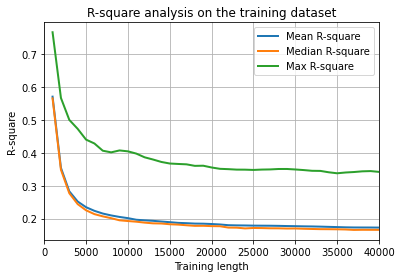

In [4]:
#################################################################
### Sensitivity analysis of training length to the performance ##
#################################################################
# Idea: plot the mean and median of Rsquare values for a 
# number of training intervals, followed by checking the 
# RMSE on the test data

n_mintrain = 1000
n_train_inc = 1000

n_train = np.arange(n_mintrain, n_maxtrain+1, n_train_inc, dtype='int')
mean_Rsq = np.zeros(len(n_train))
median_Rsq = np.zeros(len(n_train))
max_Rsq = np.zeros(len(n_train))
rmse_test = np.zeros((n_test-1, len(n_train)))
rmse_train = np.zeros((len(n_train), n_pc))

for i, trainlen in enumerate(n_train):
    # prepare the training data
    x_train, y_train, scaler = training4tendency(pcs, n_pc, trainlen, dt, 'standard_top_pc')
    # perform LR
    [linregmodel, reg_res, Rsq] = linear_regression(x_train, y_train)
    rmse_train[i,:] = np.sqrt(np.mean(reg_res**2, axis=0))
    # compute the mean and median R-square values
    mean_Rsq[i] = np.mean(Rsq)
    median_Rsq[i] = np.median(Rsq)
    max_Rsq[i] = np.max(Rsq)
    
    # check the performance on the test dataset
    normalized_test_data = scaler.transform(test_data)
    ytendLR_test =  linregmodel.predict(normalized_test_data)
    yLR_test = (ytendLR_test*dt) + normalized_test_data
    # compute the rmse
    rmse_test[:,i] = np.sqrt(np.mean((yLR_test[:-1,:] - normalized_test_data[1:,:])**2, axis=1)) 

# Analyze R-square vs training length
plt.plot(n_train, mean_Rsq, label='Mean R-square', linewidth=2)
plt.plot(n_train, median_Rsq, label='Median R-square', linewidth=2)
plt.plot(n_train, max_Rsq, label='Max R-square', linewidth=2)
plt.xlabel('Training length')
plt.ylabel('R-square')
plt.title('R-square analysis on the training dataset')
plt.xlim([0, 40000])
plt.grid()
plt.legend()
plt.show()

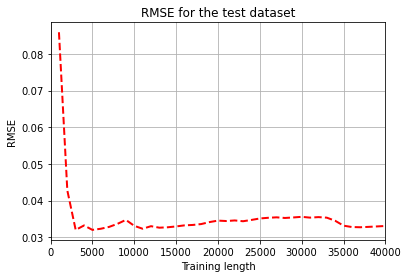

In [6]:
# Analyze RMSE on the test dataset for each training length
#for i in range(n_pc):
#    plt.scatter(n_train, rmse_test[:,i], color='b', alpha=0.2)
plt.plot(n_train,np.mean(rmse_test, axis=0),'--r',linewidth=2)
plt.xlabel('Training length')
plt.ylabel('RMSE')
plt.title('RMSE for the test dataset')
plt.xlim([0, 40000])
plt.grid()
plt.savefig('Psi1_RMSE_test_dataset_LR_150PCs.png')
plt.show()

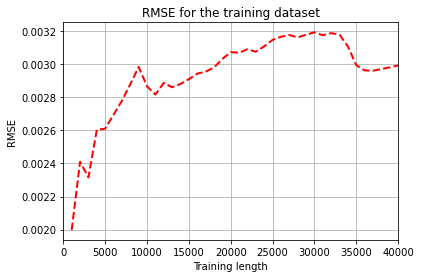

In [11]:
# Analyze reg_res for each training length
#for i in range(n_pc):
#    plt.scatter(n_train, reg_res_train[:,i], color='b', alpha=0.2)
plt.plot(n_train,np.mean(rmse_train,axis=1),'--r',linewidth=2)
plt.xlabel('Training length')
plt.ylabel('RMSE')
plt.title('RMSE for the training dataset')
plt.xlim([0, 40000])
plt.grid()
plt.savefig('Psi1_RMSE_training_dataset_LR_150PCs.png')
plt.show()

In [5]:
# Choose a training length based on the above plots and perform SLR 
n_train = n_maxtrain
x_train, y_train, scaler = training4tendency(pcs, n_pc, n_train, dt, 'standard')

# Train the Linear Regression model
start = datetime.now()
linregmodel, reg_res, r2_sco = linear_regression(x_train,y_train)
print('Training time:',datetime.now()-start)

Training time: 0:00:01.263096


In [12]:
print(np.std(reg_res, axis=0))

[0.00485922 0.01069606 0.01238515 0.01346098 0.01865938 0.01727302
 0.01530103 0.01975719 0.01839611 0.01357578 0.02042963 0.02590975
 0.01581792 0.01763156 0.0228997  0.01871383 0.02620124 0.02339165
 0.03009841 0.01507304 0.0160324  0.01603476 0.02229744 0.02591804
 0.02799379 0.02601229 0.02916702 0.02582168 0.02654617 0.0255742
 0.0261385  0.02130177 0.02104626 0.02296398 0.01747233 0.02388917
 0.02716301 0.01829207 0.02068536 0.02830359 0.02614615 0.02275522
 0.02933017 0.02319983 0.02258783 0.02553369 0.02459872 0.02245881
 0.02278343 0.0288038  0.02459611 0.02698051 0.02447755 0.02331907
 0.03006534 0.02121629 0.02341682 0.02202734 0.02081487 0.02452002
 0.02846926 0.02196338 0.02434949 0.02609386 0.02195316 0.0223661
 0.02288185 0.0250151  0.02313026 0.02730263 0.02744485 0.02290739
 0.02403076 0.02736399 0.02690612 0.02550736 0.02298668 0.02597245
 0.02426593 0.02360521 0.02868229 0.02404601 0.02880511 0.0277174
 0.02696976 0.02442397 0.02686053 0.02897162 0.02623742 0.0249234

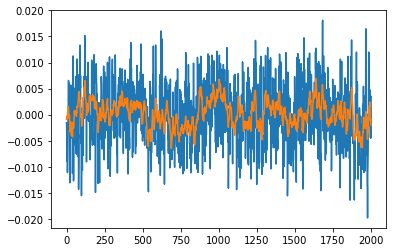

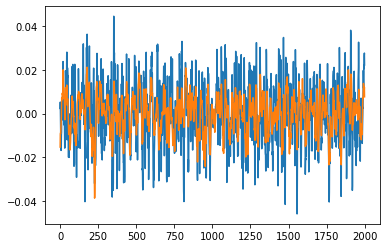

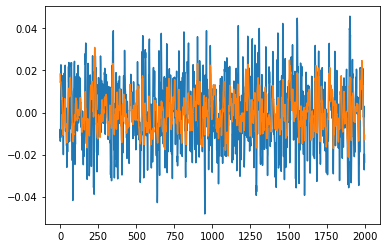

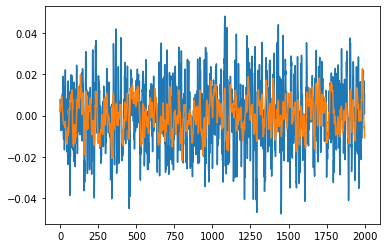

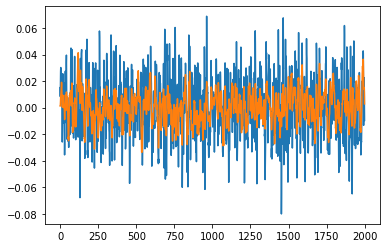

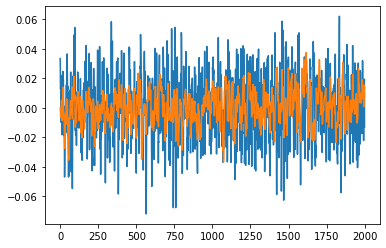

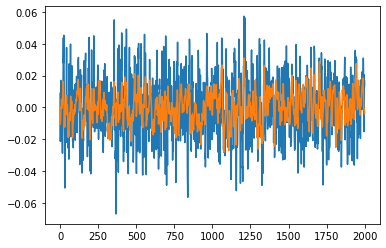

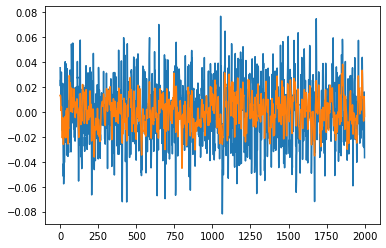

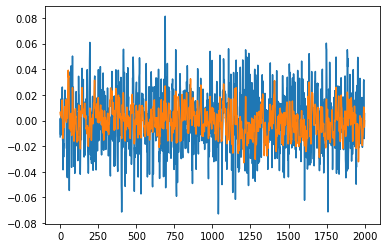

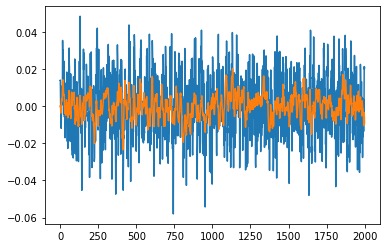

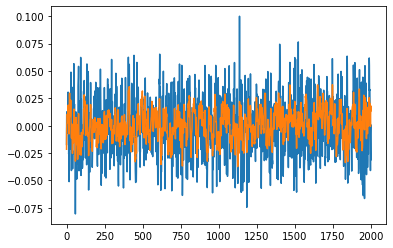

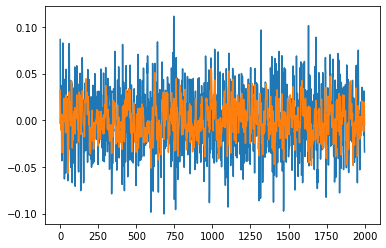

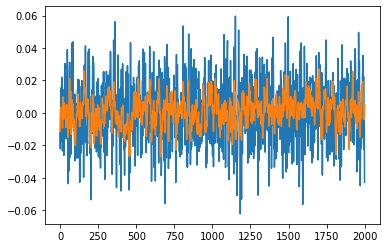

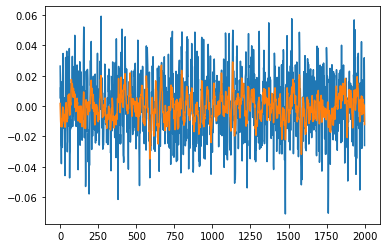

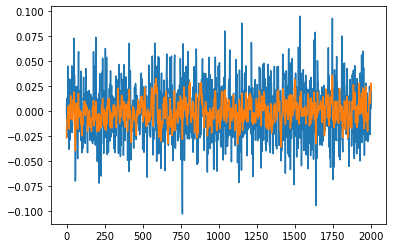

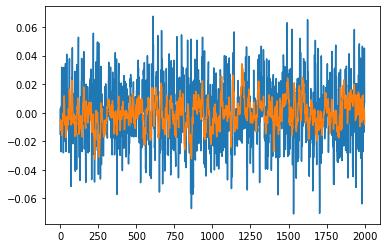

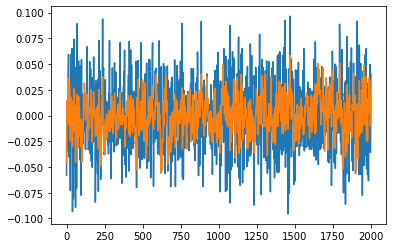

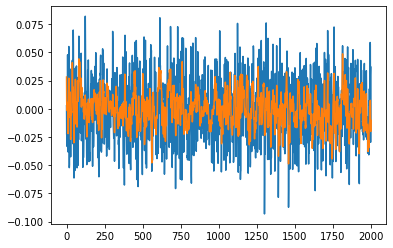

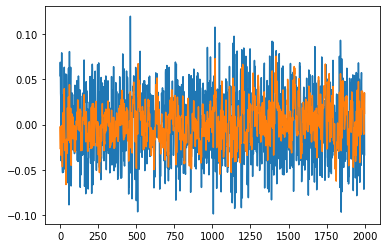

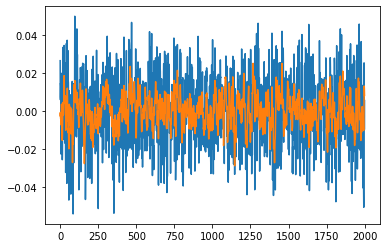

In [6]:
ypred_LR = linregmodel.predict(x_train)

for k in range(20):
    plt.plot(y_train[:2000,k])
    plt.plot(ypred_LR[:2000,k])
    plt.show()

In [3]:
####################################################################
#################### Short term forecasts ##########################
####################################################################
n_maxlead = 10  # maximum lead time steps for forecasts
n_ic = int((n_test - n_maxlead))    # Number of initial conditions 
y_pred = np.zeros([n_ic, n_maxlead, n_pc])

start = datetime.now()
for k in range(n_ic):
    #### Start Forecasts ####
    x_start = test_data[k,:]
    
    y_pred[k,:,:] = forecast(n_maxlead,n_pc,x_start,dt,linregmodel,scaler)

print('Prediction time:', datetime.now()-start)
print('Number of initial conditions:',n_ic)
print('Length of each forecast:',n_maxlead)

Prediction time: 0:00:18.225576
Number of initial conditions: 9990
Length of each forecast: 10


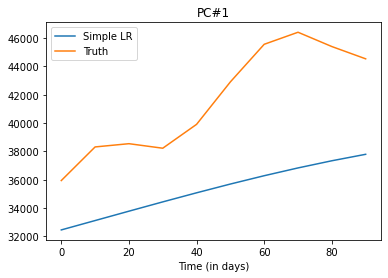

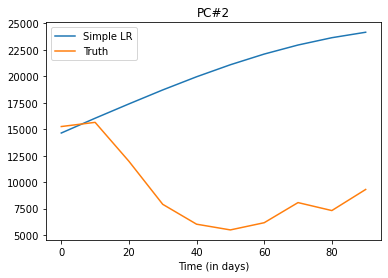

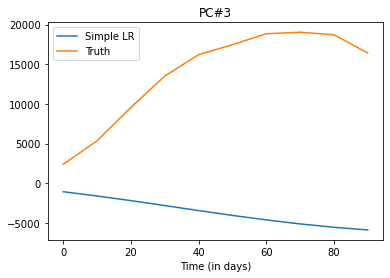

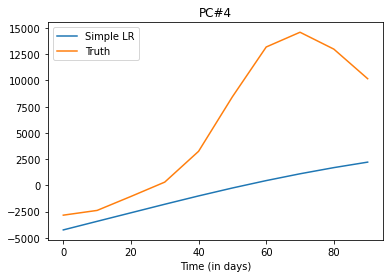

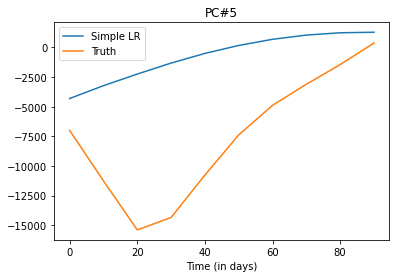

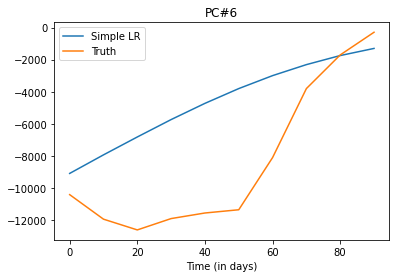

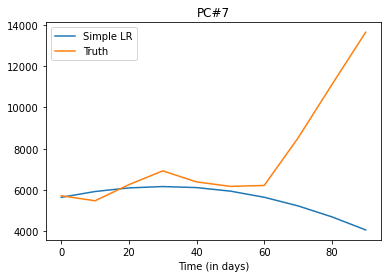

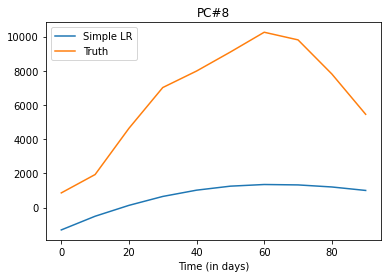

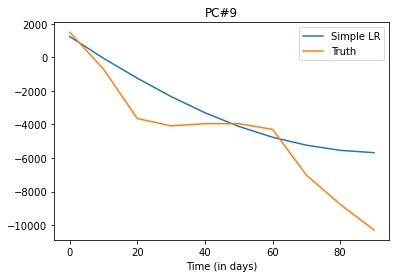

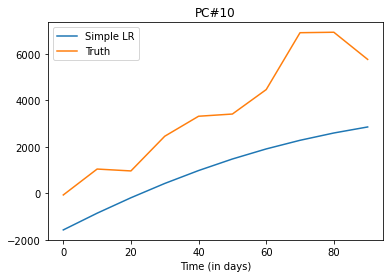

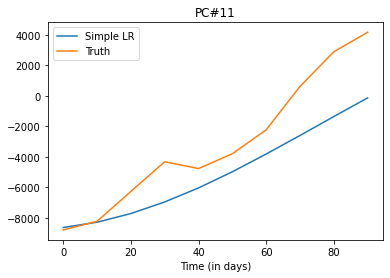

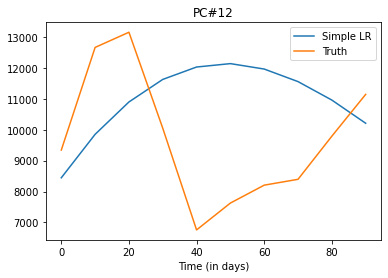

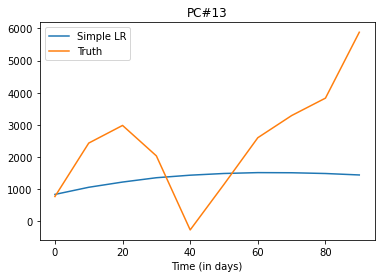

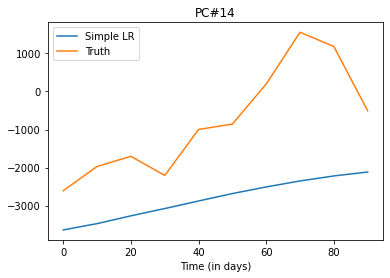

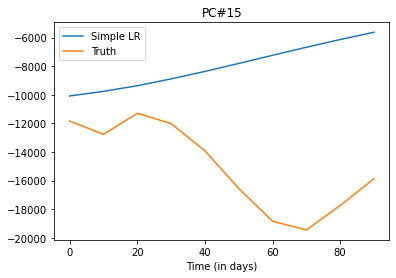

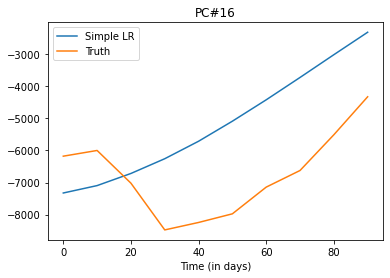

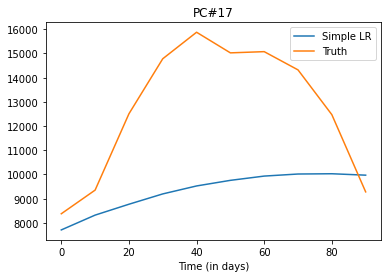

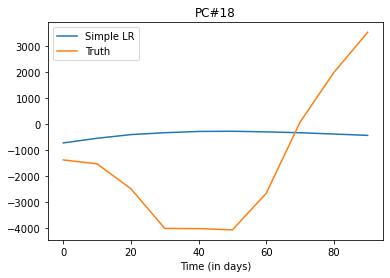

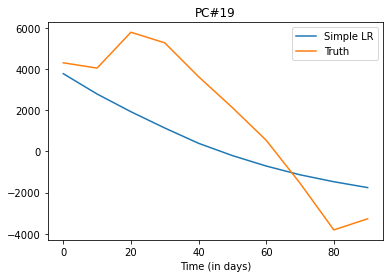

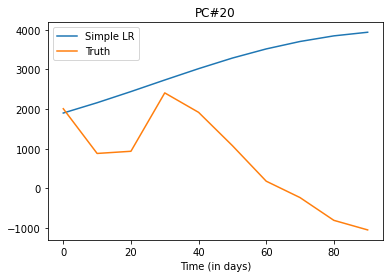

In [4]:
# Plot the predicted results against the truth for any initial condition
ic = 0       # IC index; should be 0,1,2,3..., nic-1 
for k in range(20):
    plt.figure()
    x = np.arange(0,n_maxlead*dt,10)
    plt.plot(x,y_pred[ic,:,k],label='Simple LR')
    true_ = test_data[ic+1:ic+n_maxlead+1,k]
    plt.plot(x,true_,label='Truth')
    plt.xlabel('Time (in days)')
    plt.title('PC#'+str(k+1))
    plt.legend()
    plt.show()

In [6]:
# Calculate the 'Persistence' forecast
y_persist = np.zeros([n_ic, n_maxlead, n_pc])

for k in range(n_ic):
    #### Start Forecasts ####
    x_start = test_data[k,:]
    y_persist[k,:,:] = np.repeat(np.reshape(x_start,[1,-1]),n_maxlead,axis=0)

In [5]:
psi_test_data = test_data.dot(eofs)
std_psi_test = np.mean(np.std(psi_test_data, axis=0))
print(std_psi_test)

80.32549562319018


In [22]:
####################################################################
############ Metric 1 : RMSE on the physical space #################
###### Use each data point of the test dataset as an IC ############
## Obtain 100 stochastic realizations (if applicable) for each IC ##
####################################################################
# Project the modelled PCs onto the EOFs and calculate mean RMSE
rmse = np.zeros((n_ic, n_maxlead))

start = datetime.now()
# start a parallel pool and implement thread parallelism
if __name__ == "__main__":
    rmse = Parallel(n_jobs=num_cores, prefer="threads")(delayed(RMSE)(i,test_data,y_pred,eofs,n_maxlead) for i in tqdm(range(n_ic)))

meanRMSE = np.mean(rmse, axis=0)

100%|██████████| 9990/9990 [09:18<00:00, 17.88it/s]


In [9]:
np.save('RMSE_Psi1_100days_predictions_SLR_npc=150_nic=9990_ntrain=400K_ntest=100K',meanRMSE)

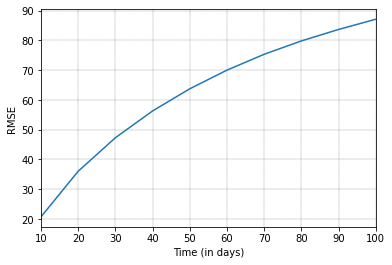

In [24]:
# Plot the mean RMSE
plt.plot(np.arange(dt,n_maxlead*dt+1,dt),meanRMSE)
plt.xlabel('Time (in days)')
plt.ylabel('RMSE')
plt.ylim([10, 80])
plt.xlim([dt, n_maxlead*dt])
plt.grid(color='k', linestyle='--', linewidth=0.2)
plt.savefig('RMSE_Psi1_50days_predictions_SLR_npc=150_nic=9995_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()

In [11]:
rmse_persist = np.zeros((n_ic, n_maxlead))

# start a parallel pool and implement thread parallelism
if __name__ == "__main__":
    rmse_persist = Parallel(n_jobs=num_cores, prefer="threads")(delayed(RMSE)(i,test_data,y_persist,eofs,n_maxlead) for i in tqdm(range(n_ic)))

meanRMSE_persist = np.mean(rmse_persist, axis=0)

100%|██████████| 9990/9990 [09:14<00:00, 18.03it/s]


In [12]:
np.save('RMSE_Psi1_100days_predictions_Persistence_npc=150_nic=9990_ntrain=400K_ntest=100K',meanRMSE_persist)

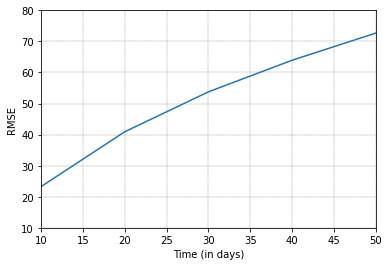

In [7]:
plt.plot(np.arange(dt,n_maxlead*dt+1,dt),meanRMSE_persist)
plt.xlabel('Time (in days)')
plt.ylabel('RMSE')
plt.ylim([10, 80])
plt.xlim([dt, n_maxlead*dt])
plt.grid(color='k', linestyle='--', linewidth=0.2)
plt.savefig('RMSE_Psi1_100days_predictions_Persistence_npc=150_nic=9990_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()
np.save('RMSE_Psi1_100days_predictions_Persistence_npc=150_nic=9990_ntrain=400K_ntest=100K',meanRMSE_persist)

In [7]:
###################################################################
# Metric 2a : Instantaneous temporal correlation coefficient (ITCC) #
###################################################################
itcc = np.zeros((n_ic, nx*ny))

start = datetime.now()
if __name__ == "__main__":
    itcc = Parallel(n_jobs=num_cores, prefer="threads")(delayed(ICC_wrapper)(i,test_data,y_pred,eofs,n_maxlead,'temporal') for i in tqdm(range(n_ic)))

print('Time taken:',datetime.now()-start)

meanitcc = np.mean(itcc, axis=0)

100%|██████████| 9990/9990 [18:05<00:00,  9.20it/s]


Time taken: 0:18:10.790755


In [ ]:
plt.imshow(meanitcc.reshape(nx,ny), origin='lower',cmap='jet')
plt.colorbar()
plt.clim([0, 1])
plt.savefig('ITCC_Psi1_100days_predictions_SLR_npc=150_nic=9990_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()
np.save('ITCC_Psi1_100days_predictions_SLR_npc=150_nic=9990_ntrain=400K_ntest=100K',meanitcc)

In [7]:
# ITCC for Persistence
itcc_persist = np.zeros((n_ic, nx*ny))

start = datetime.now()
if __name__ == "__main__":
    itcc_persist = Parallel(n_jobs=num_cores, prefer="threads")(delayed(ICC_wrapper)(i,test_data,y_persist,eofs,n_maxlead,'temporal') for i in tqdm(range(n_ic)))

print('Time taken:',datetime.now()-start)

meanitcc_persist = np.mean(itcc_persist, axis=0)

100%|██████████| 9990/9990 [17:57<00:00,  9.27it/s]


Time taken: 0:18:02.565990


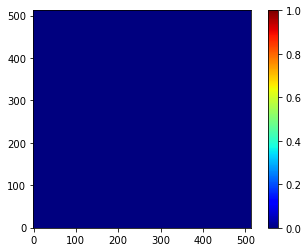

In [8]:
plt.imshow(meanitcc_persist.reshape(nx,ny), origin='lower',cmap='jet')
plt.colorbar()
plt.clim([0, 1])
plt.savefig('ITCC_Psi1_100days_predictions_Persistence_npc=150_nic=9990_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()
np.save('ITCC_Psi1_100days_predictions_Persistence_npc=150_nic=9990_ntrain=400K_ntest=100K',meanitcc_persist)

In [9]:
###################################################################
# Metric 2b : Instantaneous spatial correlation coefficient (ISCC) #
###################################################################
iscc = np.zeros((n_ic, nx*ny))

start = datetime.now()
if __name__ == "__main__":
    iscc = Parallel(n_jobs=num_cores, prefer="threads")(delayed(ICC_wrapper)(i,test_data,y_pred,eofs,n_maxlead,'spatial') for i in tqdm(range(n_ic)))

print('Time taken:',datetime.now()-start)
meaniscc = np.mean(iscc, axis=0)

100%|██████████| 9990/9990 [16:53<00:00,  9.86it/s]


Time taken: 0:16:56.989281


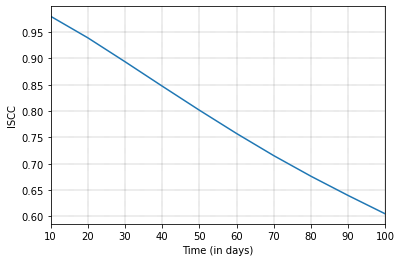

In [10]:
plt.plot(np.arange(dt,n_maxlead*dt+1,dt), meaniscc)
plt.xlabel('Time (in days)')
plt.ylabel('ISCC')
plt.xlim([dt, n_maxlead*dt])
plt.grid(color='k', linestyle='--', linewidth=0.2)
plt.savefig('ISCC_Psi1_100days_predictions_SLR_npc=150_nic=9990_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()
np.save('ISCC_Psi1_100days_predictions_SLR_npc=150_nic=9990_ntrain=400K_ntest=100K',meaniscc)

In [9]:
# ISCC for Persistence
iscc_persist = np.zeros((n_ic, nx*ny))

start = datetime.now()
if __name__ == "__main__":
    iscc_persist = Parallel(n_jobs=num_cores, prefer="threads")(delayed(ICC_wrapper)(i,test_data,y_persist,eofs,n_maxlead,'spatial') for i in tqdm(range(n_ic)))

print('Time taken:',datetime.now()-start)
meaniscc_persist = np.mean(iscc_persist, axis=0)

100%|██████████| 9990/9990 [15:47<00:00, 10.55it/s]


Time taken: 0:15:50.761417


In [10]:
np.save('ISCC_Psi1_100days_predictions_Persistence_npc=150_nic=9990_ntrain=400K_ntest=100K',meaniscc_persist)

In [3]:
################################################################
##################### Long term forecasts ######################
################################################################
n_ic = 1    # Number of initial conditions   
n_maxlead = 40000  # Prediction of 50K records for each realization
y_pred = np.zeros([n_ic, n_maxlead, n_pc])

start = datetime.now()
for k in range(n_ic):
    #### Start Forecasts ####
    x_start = test_data[k,:]
    
    y_pred[k,:,:] = forecast(n_maxlead,n_pc,
                             x_start,dt,linregmodel,scaler)

print('Prediction time:', datetime.now()-start)

Prediction time: 0:00:07.292218


In [4]:
###### Time complexity ######
# Training time = LR training time(0.5sec)
# Prediction time = time to produce one 10K days realization using one initial condition(0.2sec)

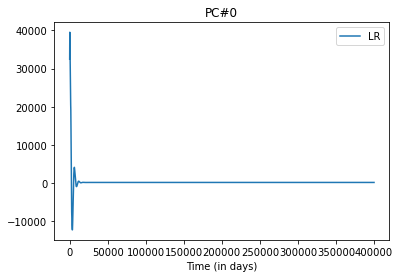

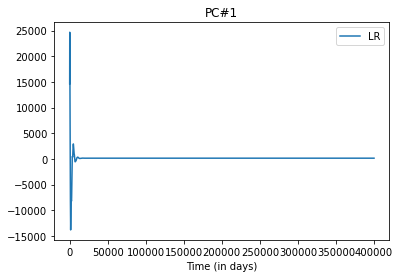

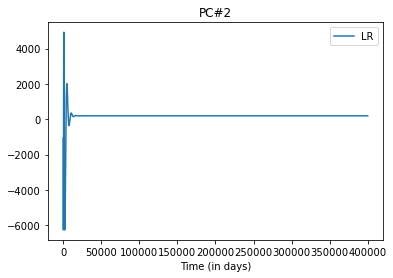

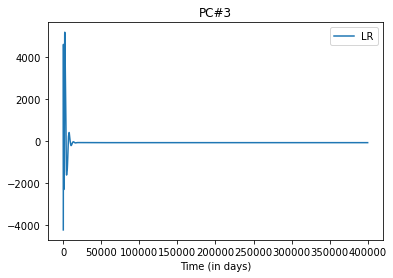

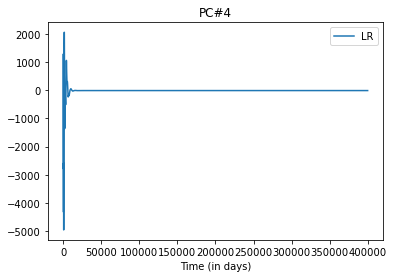

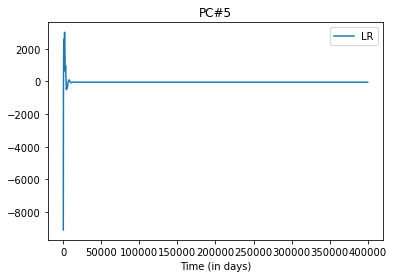

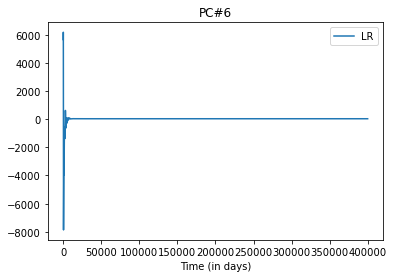

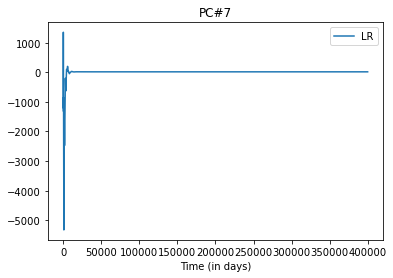

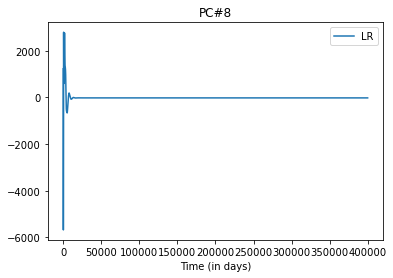

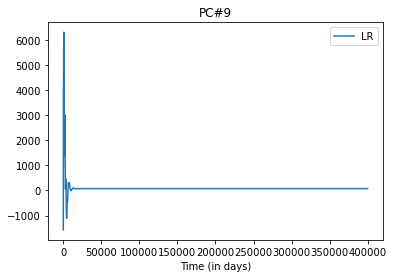

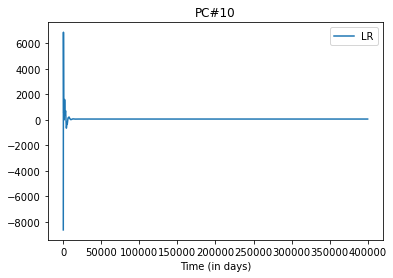

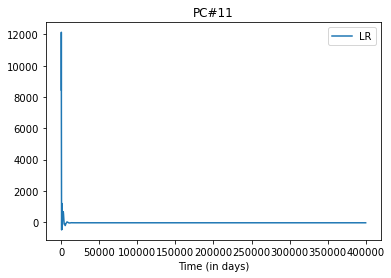

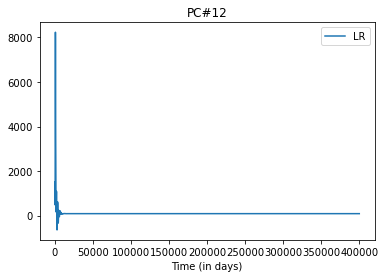

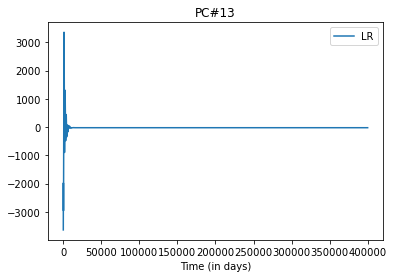

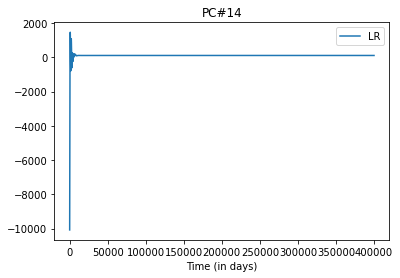

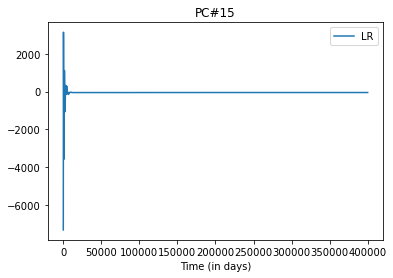

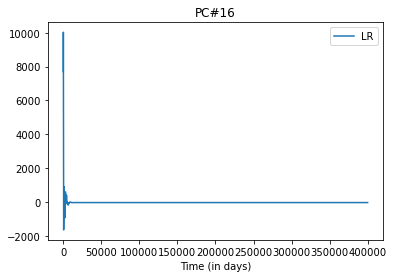

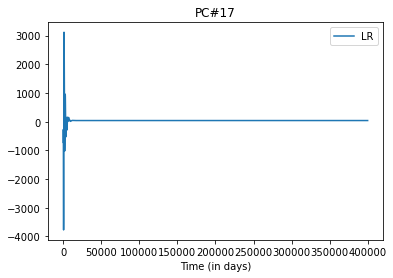

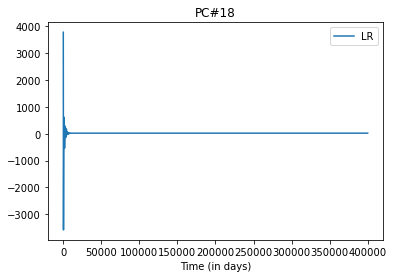

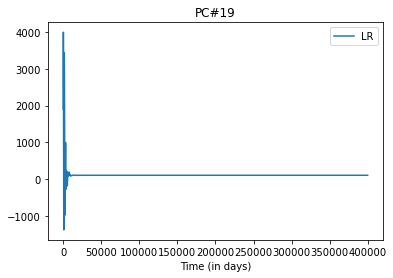

In [5]:
# Plot the predicted results against the truth
ic = 0       # Should be 0,1,2,3...,nic-1
for k in range(20):
    plt.figure()
    x = np.arange(dt,n_maxlead*dt+1,dt)
    plt.plot(x,y_pred[ic,:,k],label='LR')
    #plt.plot(test_data[ic+1:ic+1+n_maxlead,k],label='True')
    plt.title('PC#' + str(k+1))
    plt.xlabel('Time (in days)')
    plt.title('PC#'+str(k))
    plt.legend()
    plt.show()

In [6]:
################################################################
##### Metric 3-5 : Climatology, Variance, and Frequency map ####
############### using long time scale forecasts  ###############
############ frequency = 1/decorrelation time ##################
################################################################
psi1_climatology_pred = np.zeros((n_ic,nx*ny))
psi1_variance_pred = np.zeros((n_ic,nx*ny))
freq_pred = np.zeros((n_ic,nx*ny))

mean_tmp = np.zeros((nx*ny))
var_tmp = np.zeros((nx*ny))

# Project the modelled PCs onto the EOFs and calculate climatology
for kk in range(n_ic):
    psi1_pred = np.float32(y_pred[kk,:,:]).dot(np.float32(eofs))
    mean_tmp, var_tmp = mean_and_variance(psi1_pred)
    psi1_climatology_pred[kk,:] = mean_tmp
    psi1_variance_pred[kk,:] = var_tmp
    if __name__ == "__main__":
        freq_ = Parallel(n_jobs=num_cores, prefer="threads")(delayed(frequency)(i,psi1_pred,dt) for i in tqdm(range(nx*ny)))
    freq_pred[kk,:] = freq_

mean_psi1_climatology_pred = np.mean(psi1_climatology_pred, axis=0)
mean_psi1_variance_pred = np.mean(psi1_variance_pred, axis=0)
mean_freq_pred = np.mean(freq_pred, axis=0)
del psi1_pred

  1%|          | 1728/263169 [33:56<99:56:26,  1.38s/it]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



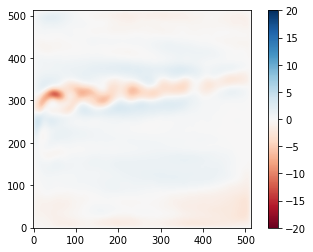

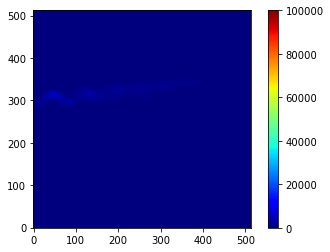

In [18]:
# Climatology and variance of the predictions
plt.imshow(mean_psi1_climatology_pred.reshape(nx,ny), origin='lower', cmap='RdBu')
plt.clim(-20, 20)
plt.colorbar()
plt.savefig('Climatology_Psi1_400Kdays_predictions_SLR_npc=150_nic=1_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()

plt.imshow(mean_psi1_variance_pred.reshape(nx,ny), origin='lower', cmap='jet')
plt.clim(0, 100000)
plt.colorbar()
plt.savefig('Variance_Psi1_400Kdays_predictions_SLR_npc=150_nic=1_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()

# Frequency map of the predictions
plt.imshow(np.array(mean_freq_pred).reshape(nx,ny), origin='lower', cmap='jet')
plt.colorbar()
plt.clim([0,4])
plt.savefig('Frequency_Psi1_400Kdays_predictions_SLR_npc=150_nic=1_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()

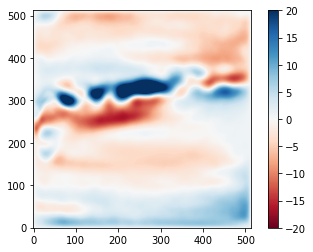

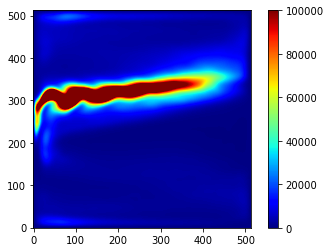

In [17]:
# Climatology and variance of the truth
plt.imshow(mean_psi1_climatology_true.reshape(nx,ny), origin='lower', cmap='RdBu')
plt.clim(-20,20)
plt.colorbar()
#plt.savefig('Climatology_Psi1_100Kdays_true_npc=150_nic=1.png',dpi=100)
plt.show()

plt.imshow(mean_psi1_variance_true.reshape(nx,ny), origin='lower', cmap='jet')
plt.colorbar()
plt.clim(0,100000)
#plt.savefig('Variance_Psi1_100Kdays_true_npc=150_nic=1.png',dpi=100)
plt.show()

In [19]:
##################################################
############# Metric 4: Frequency map ############
####### frequency = 1/decorrelation time #########
##################################################
freq_true = np.zeros((n_ic,nx*ny))
freq_pred = np.zeros((n_ic,nx*ny))

for kk in range(n_ic):
    psi1_true = test_data[kk+1:kk+n_maxlead+1,:].dot(eofs)
    # here the parallelism is done over the number of spatial points
    start = datetime.now()
    if __name__ == "__main__":
        freq_ = Parallel(n_jobs=num_cores, prefer="threads")(delayed(frequency)(i,psi1_true,dt) for i in tqdm(range(nx*ny)))
    freq_true[kk,:] = freq_
    print('Time taken:',datetime.now()-start)
    
    psi1_pred = y_pred[kk,:,:].dot(eofs)
    start = datetime.now()
    if __name__ == "__main__":
        freq_ = Parallel(n_jobs=num_cores, prefer="threads")(delayed(frequency)(i,psi1_pred,dt) for i in tqdm(range(nx*ny)))
    freq_pred[kk,:] = freq_
    print('Time taken:',datetime.now()-start)
    
# mean frequency
mean_freq_true = np.mean(freq_true, axis=0)
mean_freq_pred = np.mean(freq_pred, axis=0)

  5%|▍         | 12768/263169 [33:14<19:46:32,  3.52it/s]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/rds/general/user/na517/home/anaconda3/envs/tensorflowML/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-17245a1e687b>", line 13, in <module>
    freq_ = Parallel(n_jobs=num_cores, prefer="threads")(delayed(frequency)(i,psi1_true,dt) for i in tqdm(range(nx*ny)))
  File "/rds/general/user/na517/home/anaconda3/envs/tensorflowML/lib/python3.6/site-packages/joblib/parallel.py", line 1061, in __call__
    self.retrieve()
  File "/rds/general/user/na517/home/anaconda3/envs/tensorflowML/lib/python3.6/site-packages/joblib/parallel.py", line 940, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/rds/general/user/na517/home/anaconda3/envs/tensorflowML/lib/python3.6/multiprocessing/pool.py", line 638, in get
    self.wait(timeout)
  File "/rds/general/user/na517/home/anaconda3/envs/tensorflowML/lib/python3.6/mult

TypeError: object of type 'NoneType' has no len()

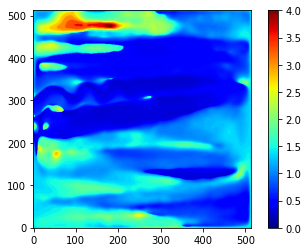

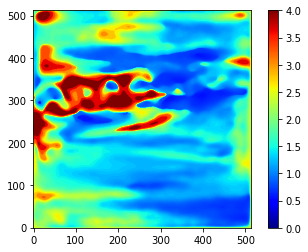

In [20]:
# SLR
plt.imshow(np.array(mean_freq_pred).reshape(nx,ny), origin='lower', cmap='jet')
plt.colorbar()
plt.clim([0,4])
plt.savefig('Frequency_Psi1_10Kdays_predictions_SLR_npc=150_nic=1_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()

# Truth
plt.imshow(np.array(mean_freq_true).reshape(nx,ny), origin='lower', cmap='jet')
plt.colorbar()
plt.clim([0,4])
plt.savefig('Frequency_Psi1_10Kdays_true_npc=150_nic=1.png',dpi=100)
plt.show()

In [3]:
############################################
###### Metric 5 : Prediction Horizon #######
############################################
ev = np.linalg.eig(linregmodel.coef_)
eigval = ev[0]
timescale = 1./np.real(eigval)
print('Prediction Horizon (in days):\n',timescale*dt)
print('Overall prediction horizon:',np.min(np.abs(timescale))*dt)

Prediction Horizon (in days):
 [  -472.94360298   -472.94360298   -718.23787677   -718.23787677
  -1407.29511716  -1407.29511716   -985.69592048   -985.69592048
  -2142.11615828  -2142.11615828  -1286.61893209  -1286.61893209
  -2018.60070698  -2018.60070698  -2630.64515668  -2630.64515668
  -1393.43887519  -1393.43887519  -1438.6085562   -1438.6085562
  -1698.98828527  -1698.98828527  -1328.14280589  -1328.14280589
  -2210.33591104  -2210.33591104  -2487.86605174  -2487.86605174
  -1807.31495379  -1807.31495379  -2036.43791454  -2036.43791454
  -1745.91470085  -1745.91470085  -2318.73781226  -2318.73781226
  -2301.83533676  -2301.83533676  -1798.03140258  -1798.03140258
  -2245.09742174  -2245.09742174  -2047.89127223  -2047.89127223
  -3235.04529049  -3235.04529049  -2786.75527214  -2786.75527214
  -1953.38909159  -1953.38909159  -1787.31412006  -1787.31412006
  -3466.70708237  -3466.70708237  -2436.66339396  -2436.66339396
  -2497.38627821  -2497.38627821  -4013.29223101  -4013.2922

In [29]:
################################################################
##################### Additional Analyses ######################
############### ICC for 10,000 days predictions ################
################################################################
icc = np.zeros((n_ic, nx*ny))

start = datetime.now()
if __name__ == "__main__":
    icc = Parallel(n_jobs=num_cores, prefer="threads")(delayed(ICC_wrapper)(i,test_data,y_pred,eofs,n_maxlead) for i in tqdm(range(n_ic)))

print('Time taken:',datetime.now()-start)
meanicc = np.mean(icc, axis=0)

100%|██████████| 1/1 [00:00<00:00, 2991.66it/s]


Time taken: 0:00:21.224473


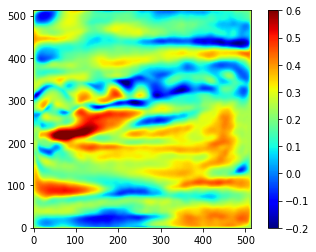

In [32]:
# Mean ICC for 10K days predictions
plt.imshow(meanicc.reshape(nx,ny), origin='lower', cmap='jet')
plt.colorbar()
plt.clim([-0.2, 0.6])
plt.savefig('ICC_Psi1_10Kdays_predictions_SLR_npc=150_nic=1_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()

In [ ]:
##########################################################
################## Additional Analyses ###################
######### Frequency map for coarse-grained data ##########
##########################################################
n_maxlag = 1000
nx_ = 129
ny_ = 129

freq_true = np.zeros((n_ic, nx_*ny_))
freq_pred = np.zeros((n_ic, nx_*ny_))

for kk in range(n_ic):
    psi1_true = test_data[kk+1:kk+n_maxlead+1,:].dot(eofs)
    psi1_true = np.reshape(psi1_true, (n_maxlead, nx, ny))
    
    psi1_pred = y_pred[kk,:,:].dot(eofs)
    psi1_pred = np.reshape(psi1_pred, (n_maxlead, nx, ny))

    # Coarse grain the dataset
    idx = np.arange(0,nx,4) # Generate the indices
    
    psi1_true_CG = np.zeros((n_maxlead,nx_,ny_))
    psi1_pred_CG = np.zeros((n_maxlead,nx_,ny_))
    
    for i in range(np.size(idx)):
        for j in range(np.size(idx)):
            psi1_true_CG[:,i,j] = psi1_true[:,idx[i],idx[j]]
            psi1_pred_CG[:,i,j] = psi1_pred[:,idx[i],idx[j]]
    
    psi1_true_CG = np.reshape(psi1_true_CG,(n_maxlead,nx_*ny_))
    psi1_pred_CG = np.reshape(psi1_pred_CG, (n_maxlead,nx_*ny_))
    
    # compute frequency
    freq_true[kk,:] = frequency_map(psi1_true_CG, \
                                    nx_, ny_, n_maxlag, dt)
        
    freq_pred[kk, :] = frequency_map(psi1_pred_CG, \
                                    nx_, ny_, n_maxlag, dt)

In [ ]:
mean_freq_pred = np.mean(freq_pred, axis=0)
mean_freq_true = np.mean(freq_true, axis=0)

In [ ]:
plt.imshow(freq_pred.reshape(nx_,ny_), origin='lower', cmap='viridis')
plt.colorbar()
plt.clim([0,0.01])
plt.title('SLR')
plt.show()

plt.imshow(freq_true.reshape(nx_,ny_), origin='lower', cmap='viridis')
plt.colorbar()
plt.clim([0,0.01])
plt.title('True')
plt.show()